In [1]:
import SimpleITK as sitk
import glob
import re
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import os
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python import keras
print(keras.__version__)

2.10.1
Num GPUs Available:  1
2.6.0


In [3]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras
from keras import backend as K

In [4]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [5]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [6]:
train_img_dir = 'E:/MRI/Ronging_train/train/Images/'
train_mask_dir = 'E:/MRI/Ronging_train/train/Masks/'

val_img_dir = 'E:/MRI/Ronging_train/val/Images/'
val_mask_dir = 'E:/MRI/Ronging_train/val/Masks/'

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


In [7]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [8]:
#wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#iou = true_positives / (true_positives + false_positives + false_negatives)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [9]:
callbacks = [
             keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                                           patience=3, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath = 'E:/MRI/Rongin restults/first/model_.{epoch:02d}-{val_loss:.6f}.h5',
                             verbose=0, save_best_only=True, save_weights_only = True),
             keras.callbacks.CSVLogger('E:/MRI/Rongin restults/first/training_log/training_unet.csv', separator=",", append=True)
             ]

In [10]:
kernel_initializer =  'he_uniform' 

In [11]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes,dropout=0.1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

In [12]:
model = unet_model(128, 128, 128, 3, 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [18]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  1312        ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

In [25]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('E:/MRI/Rongin restults/first/Model/unet.hdf5')

Epoch 1/50
277/277 [==============================] - 104s 370ms/step - loss: 0.8248 - accuracy: 0.9227 - iou_score: 0.2304 - f1-score: 0.2389 - val_loss: 0.8123 - val_accuracy: 0.9452 - val_iou_score: 0.2363 - val_f1-score: 0.2429 - lr: 2.0000e-05
Epoch 2/50
277/277 [==============================] - 105s 381ms/step - loss: 0.8049 - accuracy: 0.9516 - iou_score: 0.2379 - f1-score: 0.2437 - val_loss: 0.8122 - val_accuracy: 0.9452 - val_iou_score: 0.2363 - val_f1-score: 0.2429 - lr: 2.0000e-05
Epoch 3/50
277/277 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.9517 - iou_score: 0.2379 - f1-score: 0.2438
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
277/277 [==============================] - 103s 372ms/step - loss: 0.8048 - accuracy: 0.9517 - iou_score: 0.2379 - f1-score: 0.2438 - val_loss: 0.8122 - val_accuracy: 0.9452 - val_iou_score: 0.2363 - val_f1-score: 0.2429 - lr: 2.0000e-05
Epoch 4/50
277/277 [==============================] -

KeyboardInterrupt: 

In [13]:
kernel_initializer =  'he_uniform' 

In [15]:
def unet_modelB(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes,dropout=0.1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    b1 = BatchNormalization()(c1)
    p1 = MaxPooling3D((2, 2, 2))(b1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    b2 = BatchNormalization()(c2)
    p2 = MaxPooling3D((2, 2, 2))(b2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    b3 = BatchNormalization()(c3)
    p3 = MaxPooling3D((2, 2, 2))(b3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    b4 = BatchNormalization()(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(b4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    b5 = BatchNormalization()(c5) 
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(b5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    b7 = BatchNormalization()(u7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    b8 = BatchNormalization()(u8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    b9 = BatchNormalization()(u9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(b9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

In [16]:
model = unet_modelB(128, 128, 128, 3, 4)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [19]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
                  callbacks=callbacks
          )

model.save('E:/MRI/Rongin restults/first/Model/unet.hdf5')

Epoch 1/50
277/277 [==============================] - 118s 384ms/step - loss: 0.6773 - accuracy: 0.8544 - iou_score: 0.2860 - f1-score: 0.3366 - val_loss: 0.6259 - val_accuracy: 0.9146 - val_iou_score: 0.3379 - val_f1-score: 0.4037 - lr: 1.0000e-04
Epoch 2/50
277/277 [==============================] - 108s 390ms/step - loss: 0.4478 - accuracy: 0.9699 - iou_score: 0.4801 - f1-score: 0.5765 - val_loss: 0.5245 - val_accuracy: 0.9260 - val_iou_score: 0.4193 - val_f1-score: 0.5056 - lr: 1.0000e-04
Epoch 3/50
277/277 [==============================] - 108s 391ms/step - loss: 0.3882 - accuracy: 0.9737 - iou_score: 0.5289 - f1-score: 0.6292 - val_loss: 0.5261 - val_accuracy: 0.9460 - val_iou_score: 0.4175 - val_f1-score: 0.4964 - lr: 1.0000e-04
Epoch 4/50
277/277 [==============================] - 108s 391ms/step - loss: 0.3601 - accuracy: 0.9763 - iou_score: 0.5532 - f1-score: 0.6550 - val_loss: 0.5036 - val_accuracy: 0.9617 - val_iou_score: 0.4370 - val_f1-score: 0.5169 - lr: 1.0000e-04
Epoc

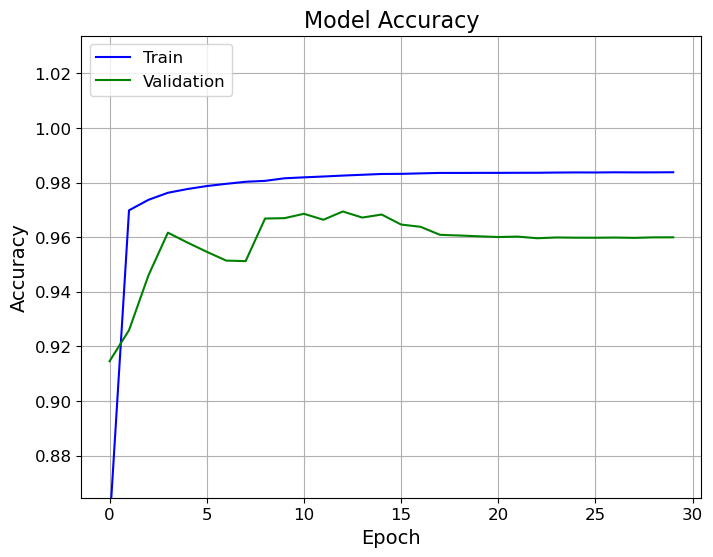

In [20]:
# Get the metrics from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set the figure size
fig = plt.figure(figsize=(8, 6))

# Plot the accuracy
plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='green')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the y-axis limits
min_val_acc = min(val_accuracy)
max_acc = max(accuracy)
max_val_acc = max(val_accuracy)
plt.ylim([min_val_acc - 0.05, max(max_acc, max_val_acc) + 0.05])

# Add a grid
plt.grid(True)

# Add a legend
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)

# Show the plot
plt.show()

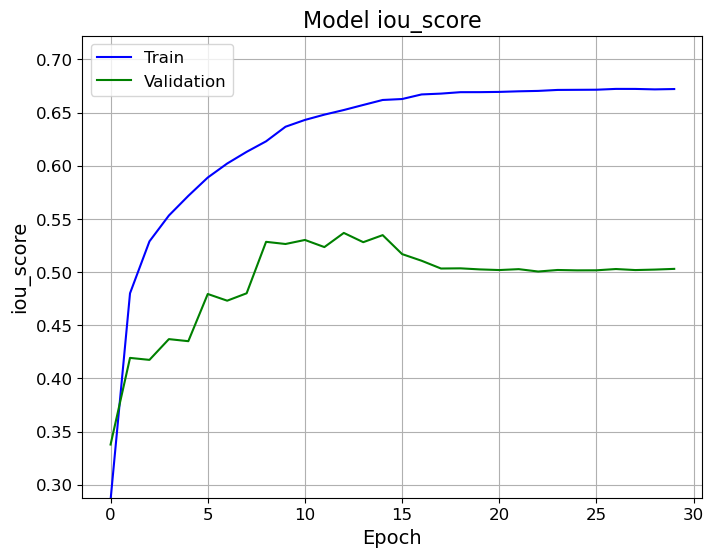

In [21]:
# Get the metrics from the history
accuracy = history.history['iou_score']
val_accuracy = history.history['val_iou_score']

# Set the figure size
fig = plt.figure(figsize=(8, 6))

# Plot the accuracy
plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='green')
plt.title('Model iou_score', fontsize=16)
plt.ylabel('iou_score', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the y-axis limits
min_val_acc = min(val_accuracy)
max_acc = max(accuracy)
max_val_acc = max(val_accuracy)
plt.ylim([min_val_acc - 0.05, max(max_acc, max_val_acc) + 0.05])

# Add a grid
plt.grid(True)

# Add a legend
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)

# Show the plot
plt.show()

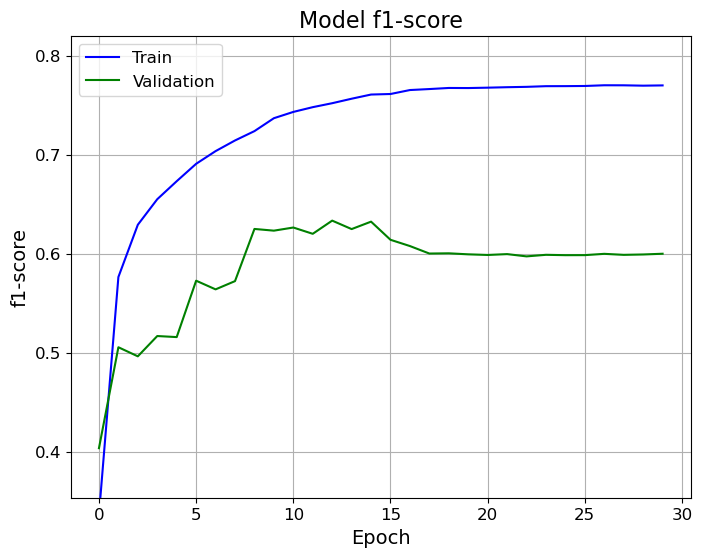

In [22]:
# f1-score
# Get the metrics from the history
accuracy = history.history['f1-score']
val_accuracy = history.history['val_f1-score']

# Set the figure size
fig = plt.figure(figsize=(8, 6))

# Plot the accuracy
plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='green')
plt.title('Model f1-score', fontsize=16)
plt.ylabel('f1-score', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the y-axis limits
min_val_acc = min(val_accuracy)
max_acc = max(accuracy)
max_val_acc = max(val_accuracy)
plt.ylim([min_val_acc - 0.05, max(max_acc, max_val_acc) + 0.05])

# Add a grid
plt.grid(True)

# Add a legend
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)

# Show the plot
plt.show()